In [ ]:
!pip install pymorphy2

In [ ]:
import json

import bz2
import re
from tqdm.notebook import tqdm
from collections import Counter
import pymorphy2

import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, lsimodel
from gensim import similarities

%matplotlib inline
%pylab inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Populating the interactive namespace from numpy and matplotlib


In [ ]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

0it [00:00, ?it/s]

# Домашнее задание по NLP # 1 [100 баллов]

Классификация по тональности

В этом домашнем задании необходимо классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. Тексты хранятся в json-ах в массиве responses.

In [ ]:
df_banki = pd.DataFrame(responses)
df_banki[:5]

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


## Часть 1. Анализ текстов [40/100]
### 1.1 Подсчет количества отзывов в разных городах и на разные банки 

In [ ]:
df_banki_message_stat = df_banki.groupby(['bank_name', 'city']).count().reindex(columns=['bank_license'])
df_banki_message_stat.rename(columns={'bank_license': 'message_count'}, inplace=True)
df_banki_message_stat = df_banki_message_stat.sort_values('message_count', ascending=False)
df_banki_message_stat[:10]

,,message_count
bank_name,city,
Сбербанк России,г. Москва,8146
Альфа-Банк,г. Москва,3871
Русский Стандарт,г. Москва,2801
ВТБ 24,г. Москва,2714
Сбербанк России,г. Санкт-Петербург,2434
Московский Кредитный Банк,г. Москва,2348
Тинькофф Банк,г. Москва,2339
Хоум Кредит Банк,г. Москва,2143
Национальный Банк «Траст»,г. Москва,1654


### 1.2 Постройте гистограмы длин слов в символах и в словах

In [ ]:
class TextPrepare:

    def __init__(self, pymorphy, stopwords=None, vocab=None):
        """ Подготовка и операции с текстом

        Параметры
        ---------
        pymorphy : MorphAnalyzer
          Экземпляр MorphAnalyzer для лемматизации и поиска тегов
        stopwords : list
          Список стоп-слов, по умолчанию None
        vocab : dict
          Словарь в формате {слово: {'lemma': лемма, 'pos': pos-тег}}
          В данном словаре класс будет искать леммы и pos-теги.
          Если слова в словаре не будет, то поиск будет осуществляться через
          pymorphy. И неизвестное слово будет добавлено в словарь.
          Можно задать пустой словарь, тогда он будет наполняться заново.
        """

        assert isinstance(pymorphy, pymorphy2.MorphAnalyzer), "pymorphy доджен быть объектом pymorphy2.MorphAnalyzer"
        if stopwords is not None:
            assert isinstance(stopwords, list), "stopwords должен быть объектом list"
        self._stopwords = stopwords
        self._pymorphy = pymorphy
        if not isinstance(vocab, dict):
            self._vocab = {}
        else:
            self._vocab = vocab


    def _lemmatize(self, word):
        """Лемматизация и поиск pos-тега с помощью pymorphy"""
        parse = self._pymorphy.parse(word)[0]
        lemma = parse.normal_form
        pos = parse.tag.POS
        return lemma, pos


    def fit(self, text):
        """ Подготовка текста
        """
        text = text.lower().strip()
        text = re.sub(r'[^А-Яа-яA-Za-z ]', ' ', text)
        self._tokens = nltk.tokenize.word_tokenize(text, language='russian')
        del(text)
        self._is_fitted = True


    def _get_tokens_and_pos(self, lemmatize=False, stopwords=False, pos_enable=False):
        """ Получение токенов и pos-тегов

        Параметры
        ---------
        lemmatize : bool
          Флаг лемматизации. Если True, будет выполнена лемматизация.
          По умолчанию False.
        stopwords : bool
          Флаг фильтрации по стоп-словам. Если True, будет выполнена фильтрация.
          По умолчанию False.
        pos_enable : bool
          Флаг поиска pos-тегов. Если True, в выдачу будет добавлен pos-тег.
          По умолчанию False.


        Результат
        ---------
        tokens : list
          Если pos_enable = False, формат [токен1, токен2, ... ]
          Если pos_enable = True, формат [(токен1, pos1), (токен2, pos2), ... ]
        """ 

        if not self._is_fitted:
            raise Exception("Требуется предварительно запустить метод fit")

        tokens = self._tokens 

        if stopwords and self._stopwords is None:
            raise ValueError("Не задан список стоп-слов")
        
        if stopwords:
            tokens = [token for token in self._tokens if token not in self._stopwords]

        if lemmatize or pos_enable:

            tokens_lemm = []
            for token in tokens:
                if token not in self._vocab:
                    lemma, pos = self._lemmatize(token)
                    self._vocab[token] = {'lemma': lemma, 'pos': pos}
                if pos_enable:
                    tokens_lemm.append((self._vocab[token]['lemma'], 
                                        self._vocab[token]['pos']))
                else:
                    tokens_lemm.append(self._vocab[token]['lemma'])

            tokens = tokens_lemm

        return tokens
    
    
    def get_tokens(self, lemmatize=False, stopwords=False):
        """ Получение токенов

        Параметры
        ---------
        emmatize : bool
          Флаг лемматизации. Если True, будет выполнена лемматизация.
          По умолчанию False.
        stopwords : bool
          Флаг фильтрации по стоп-словам. Если True, будет выполнена фильтрация.
          По умолчанию False.

        Результат
        ---------
        tokens : list
          Формат [токен1, токен2, ... ]
        """
        tokens = self._get_tokens_and_pos(lemmatize=lemmatize, 
                                          stopwords=stopwords, pos_enable=False)
        return tokens


    def get_pos_tags(self, tag_filter=None, stopwords=False):
        """ Получение токенов с pos-тегами. Токены будут лемматизированы.

        Параметры
        ---------
        tag_filter : str
          POS-тег для фильтрации выдачи. По умолчанию None.
        stopwords : bool
          Флаг фильтрации по стоп-словам. Если True, будет выполнена фильтрация.
          По умолчанию False.

        Результат
        ---------
        tokens : list
          Формат: [(токен1, pos1), (токен2, pos2), ... ]
        """
        tokens = self._get_tokens_and_pos(stopwords=stopwords, pos_enable=True)
        return tokens

    def seriallize(self, path=None):
        """Сохранение параметров модели
        Сохраняется только vocab и stopwords
        """
        model_params = {'vocab': self._vocab, 'stopwords': self._stopwords}
        if not path:
            path = 'text_prepare_model.json'
        with open(path, 'w', encoding='utf-8') as file:
            json.dump(model_params, file)


    @classmethod
    def load_from_file(cls, pymorphy, path):
        """ Создание модели с параметрами из файла

        Параметры
        ---------
        pymorphy : MorphAnalyzer
          Экземпляр MorphAnalyzer для лемматизации и поиска тегов
        path:
          Путь к файлу модели в формате json
        
        Результат
        ---------
        text_prep_model : TextPrepare
        """

        with open(path, 'r', encoding='utf-8') as file:
            model_params = json.load(file)

        return cls(pymorphy=pymorphy, stopwords=model_params.get('stopwords'), 
                   vocab=model_params.get('vocab'))

Найдем статистику количества символов в словах и количества слов в текстах

In [ ]:
# Список счетчиков символов в словах
symbols_count = []
# Список счетчиков слов в текстах
words_count = []

stopwords = nltk.corpus.stopwords.words('russian')
pymorphy = pymorphy2.MorphAnalyzer(lang='ru')

# Файл с  параметрами ранее обученной модели
model_param_file = 'text_prepare_model.json'
# Подгружаем словарь с леммами и pos-тегами из ранее обученного объекта класса TextPrepare
# Это поможет не запускать pymorphy2 во время лемматизации
model_vocab = TextPrepare.load_from_file(pymorphy=pymorphy, path=model_param_file)._vocab

# Список обученных объектов TextPrepare для каждого текста
# в порядке их следования в датафрейме
text_prep_models = []

tokenize_bar = tqdm(total=len(df_banki.text.values))
for text in df_banki.text.values:
    text_prep_model = TextPrepare(pymorphy=pymorphy, stopwords=stopwords, vocab=model_vocab)
    text_prep_model.fit(text)
    text_prep_models.append(text_prep_model)
    tokens = text_prep_model.get_tokens(lemmatize=False, stopwords=False)
    for token in tokens:
        symbols_count.append(len(token))
    words_count.append(len(tokens))
    tokenize_bar.update(1)
tokenize_bar.close()

  0%|          | 0/153499 [00:00<?, ?it/s]

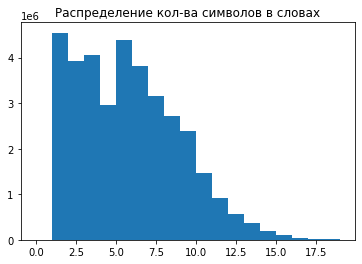

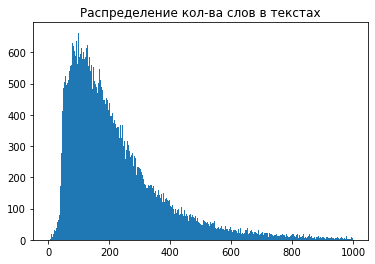

In [ ]:
plt.hist(symbols_count, bins=np.arange(0, 20))
plt.title("Распределение кол-ва символов в словах")
plt.show()

plt.hist(words_count, bins=np.arange(0, 1000))
plt.title("Распределение кол-ва слов в текстах")
plt.show()

# 1.3 Поиск самых частых значений

In [ ]:
def get_object_counts(text_prep_models, top_n=None, stopwords=False, 
                      lemmatize=False, print_result=False, pos_tag=None):

    stat_tokens = Counter()
    for text_prep_model in text_prep_models:
        if pos_tag:
            pos_tag = str(pos_tag).upper()
            tokens = text_prep_model.get_pos_tags(stopwords=stopwords)
            tokens = [token for token, pos in tokens if pos == pos_tag]
        else:
            tokens = text_prep_model.get_tokens(stopwords=stopwords, lemmatize=lemmatize)
        stat_tokens.update(tokens)

    stat_tokens = sorted(stat_tokens.items(), key=lambda x: x[1], reverse=True)
    if top_n and len(stat_tokens) > top_n:
        stat_tokens = stat_tokens[:top_n]

    if print_result:
        for position, (word, count) in enumerate(stat_tokens, 1):
            print(f'{position}: {word} (частота {count})')

    return stat_tokens

## 1.3.1 Десять самых частых слов

In [ ]:
_ = get_object_counts(text_prep_models=text_prep_models, 
                      top_n=10, print_result=True)

1: в (частота 1330535)
2: и (частота 1058982)
3: не (частота 855332)
4: на (частота 707931)
5: что (частота 640057)
6: я (частота 577484)
7: с (частота 463754)
8: по (частота 372765)
9: мне (частота 320958)
10: банка (частота 275899)


## 1.3.2 Десять самых частых слов без стоп-слов



In [ ]:
_ = get_object_counts(text_prep_models=text_prep_models, 
                      stopwords=True, top_n=10, print_result=True)

1: банка (частота 275899)
2: банк (частота 215411)
3: это (частота 183365)
4: деньги (частота 131200)
5: карту (частота 105827)
6: карты (частота 101821)
7: т (частота 91715)
8: кредит (частота 81119)
9: день (частота 76552)
10: банке (частота 72162)


## 1.3.3 Десять самых частых лемм

In [ ]:
_ = get_object_counts(text_prep_models=text_prep_models, 
                      stopwords=True, lemmatize=True, top_n=10, 
                      print_result=True)

1: банк (частота 668522)
2: карта (частота 334994)
3: это (частота 200057)
4: деньга (частота 179818)
5: день (частота 173116)
6: мой (частота 163042)
7: кредит (частота 156153)
8: который (частота 149016)
9: отделение (частота 144049)
10: клиент (частота 136889)


## 1.3.4 Десять самых частых существительных

In [ ]:
_ = get_object_counts(text_prep_models=text_prep_models, 
                      stopwords=True, lemmatize=True, pos_tag='NOUN', top_n=10, 
                      print_result=True)

1: банк (частота 668522)
2: карта (частота 334994)
3: деньга (частота 179818)
4: день (частота 173116)
5: кредит (частота 156153)
6: отделение (частота 144049)
7: клиент (частота 136889)
8: сотрудник (частота 134168)
9: счёт (частота 126894)
10: сумма (частота 111232)


## 1.4 Построение кривых Ципфа и Хипса
### 1.4.1 Кривая Ципфа

Зако́н Ци́пфа — эмпирическая закономерность распределения частоты слов естественного языка: если все слова языка (или просто достаточно длинного текста) упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n (так называемому рангу этого слова). Например, второе по используемости слово встречается примерно в два раза реже, чем первое, третье — в три раза реже, чем первое, и так далее. 

In [ ]:
def plot_zakon_cipfa(text_prep_models, size=200):
    stat_tokens = get_object_counts(text_prep_models, top_n=size, 
                                    stopwords=True, lemmatize=True)
    a_param = 0.07
    stat_tokens = [(word, a_param/rang) for rang, (word, count) in enumerate(stat_tokens, 1)]

    for rang, (word, _) in enumerate(stat_tokens):
        print(f"Ранг {rang}: {word}")

    f_val = [val for _, val in stat_tokens]
    plt.plot(np.arange(1, len(stat_tokens)+1), f_val)
    plt.xticks(np.arange(1, len(stat_tokens)+1))
    plt.title("Кривая Ципфа")
    plt.xlabel("Ранг слова")
    plt.grid()
    plt.show()

Ранг 0: банк
Ранг 1: карта
Ранг 2: это
Ранг 3: деньга
Ранг 4: день
Ранг 5: мой
Ранг 6: кредит
Ранг 7: который
Ранг 8: отделение
Ранг 9: клиент


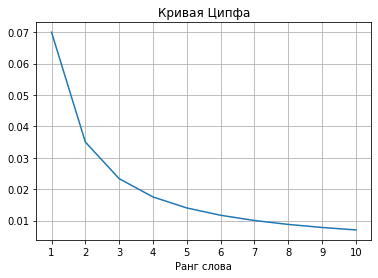

In [ ]:
plot_zakon_cipfa(text_prep_models=text_prep_models, size=10)

### 1.4.2 Кривая Хипса

Закон Хердана-Хипса – имперический закон, согласно которому количество уникальных слов в тексте зависит от длины текста.

In [ ]:
def plot_zakon_hipsa(k=20, b=0.5):
    x = np.arange(1, 10000)
    y = x**b * k
    plt.plot(x, y)
    plt.title("Кривая Хипса")
    plt.ylabel("Уникальные слова")
    plt.xlabel("Длина текста")
    plt.grid()
    plt.show()

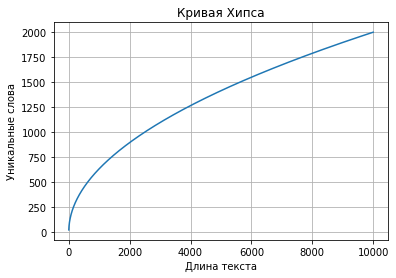

In [ ]:
plot_zakon_hipsa()

## 1.5 Частоты слов
### 1.5.1 Какое слово встречается чаще, "сотрудник" или "клиент"?

In [ ]:
stat_tokens = get_object_counts(text_prep_models, stopwords=True, lemmatize=True)
stat_tokens = dict(stat_tokens)

In [ ]:
word1 = 'сотрудник'
word2 = 'клиент'

word1_counter = stat_tokens.get(word1)
word2_counter = stat_tokens.get(word2)

assert word1_counter is not None, f"Слово {word1} отсутствует в тексте"
assert word2_counter is not None, f"Слово {word2} отсутствует в тексте"

if word1_counter > word2_counter:
    print(f"{word1.upper()} встречается чаще ({word1_counter} против {word2_counter})")
elif word1_counter < word2_counter:
    print(f"{word1.upper()} встречается чаще ({word2_counter} против {word1_counter})")
else:
    print(f"{word1.upper()} и {word2.upper()} встречаются одинаково ({word1_counter})")

СОТРУДНИК встречается чаще (136889 против 134168)


### 1.5.2 Какое слово встречается чаще, "мошенничество" или "доверие"?

In [ ]:
word1 = 'мошенничество'
word2 = 'доверие'

word1_counter = stat_tokens.get(word1)
word2_counter = stat_tokens.get(word2)

assert word1_counter is not None, f"Слово {word1} отсутствует в тексте"
assert word2_counter is not None, f"Слово {word2} отсутствует в тексте"

if word1_counter > word2_counter:
    print(f"{word1.upper()} встречается чаще ({word1_counter} против {word2_counter})")
elif word1_counter < word2_counter:
    print(f"{word1.upper()} встречается чаще ({word2_counter} против {word1_counter})")
else:
    print(f"{word1.upper()} и {word2.upper()} встречаются одинаково ({word1_counter})")

МОШЕННИЧЕСТВО встречается чаще (3244 против 2108)


## 1.6 В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

Для оценки сформируем два документа:
- документ со всеми положительными отзывами;
- документ со всеми отрицательными отзывами.

В рамках указанных документов обучим модель TF-IDF и найдем значимые n-граммы для каждого документа.

In [ ]:
negative_text = ""
positive_text = ""

for index, df_row in enumerate(df_banki.itertuples()):
    if df_row.rating_grade == 1:
        negative_text += ' '.join(text_prep_models[index].get_tokens(stopwords=True, lemmatize=True)) + ' '
    elif df_row.rating_grade == 5:
        positive_text += ' '.join(text_prep_models[index].get_tokens(stopwords=True, lemmatize=True)) + ' '

documents = [positive_text, negative_text]

In [ ]:
tf_idf_model = TfidfVectorizer(ngram_range=(1,2))
tfidf_result = tf_idf_model.fit_transform(documents).todense()

# Свойство vocabulary_ содержит индексированный словарь слов модели
# Нам нужно по индексу находить конкретное слово, создаем такой словарь
tfidf_vocab = dict(zip(tf_idf_model.vocabulary_.values(),tf_idf_model.vocabulary_.keys()))

In [ ]:
# Находим 10 индексов n-грамм с максимальными значениями TF-IDF для позитивных примеров
top_pos_index = np.ravel(np.argsort(tfidf_result[0]))[::-1][:10]
# Находим 10 индексов n-грамм с максимальными значениями TF-IDF для негативных примеров
top_neg_index =np.ravel(np.argsort(tfidf_result[1]))[::-1][:10]

# Находим ТОП-10 n-грамм с максимальным значением TF-IDF для позитивных примеров
top_pos_features = [tfidf_vocab[index] for index in top_pos_index]
# Находим ТОП-10 n-грамм с максимальным значением TF-IDF для негативных примеров
top_neg_features = [tfidf_vocab[index] for index in top_neg_index]

# Находим значения TF-IDF n-грамм для позитивных примеров
top_pos_tfidf = [tfidf_result[0, index] for index in top_pos_index]
# Находим значения TF-IDF n-грамм для негативных примеров
top_neg_tfidf = [tfidf_result[1, index] for index in top_neg_index]

In [ ]:
print('Самые важные n-граммы для позитивных сообщений\n')
for index, (word, tfidf) in enumerate(zip(top_pos_features, top_pos_tfidf), 1):
    print(f'{index}: {word} ({tfidf})')

print('Самые важные n-граммы для негативных сообщений\n')
for index, (word, tfidf) in enumerate(zip(top_neg_features, top_neg_tfidf), 1):
    print(f'{index}: {word} ({tfidf})')

Самые важные n-граммы для позитивных сообщений

1: банк (0.6384085229888494)
2: карта (0.2455695532418993)
3: это (0.1660616585713556)
4: очень (0.1533771394855191)
5: день (0.13315813333097695)
6: кредит (0.13302132033621447)
7: клиент (0.13015801980297095)
8: отделение (0.1272360851291149)
9: который (0.11784485027434692)
10: сотрудник (0.11519654159001587)
Самые важные n-граммы для негативных сообщений

1: банк (0.5590533039888984)
2: карта (0.28425504884224523)
3: это (0.17767257398912706)
4: деньга (0.1705628290915602)
5: день (0.1614465779668716)
6: мой (0.14842756198283633)
7: отделение (0.145948216070935)
8: который (0.13510720257274983)
9: кредит (0.13075854744070944)
10: сотрудник (0.12982021791081003)


# Часть 2. Тематическое моделирование [20/100]

##2.1 Построение несколько тематических моделей коллекции документов с разным числом тем.

### 2.1.1 Тематическое моделирование LSI, кол-во тем = 50

In [ ]:
all_texts = [text_prep_model.get_tokens(stopwords=True, lemmatize=True) 
             for text_prep_model in text_prep_models]

dictionary = Dictionary(all_texts)
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gs_tfidf = TfidfModel(corpus)
corpus_tfidf = gs_tfidf[corpus]

In [ ]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=50)
lsi.show_topics(5)

[(0,
  '0.189*"карта" + 0.133*"кредит" + 0.114*"деньга" + 0.108*"заявление" + 0.105*"счёт" + 0.100*"банкомат" + 0.100*"вклад" + 0.099*"отделение" + 0.095*"сбербанк" + 0.095*"сумма"'),
 (1,
  '-0.386*"вклад" + 0.357*"кредит" + -0.210*"банкомат" + -0.166*"карта" + 0.166*"страховка" + 0.146*"задолженность" + 0.143*"платёж" + 0.138*"погашение" + -0.118*"деньга" + 0.116*"звонок"'),
 (2,
  '-0.492*"вклад" + 0.286*"банкомат" + 0.220*"карта" + 0.185*"сбербанк" + 0.136*"заявление" + -0.134*"кредит" + 0.120*"деньга" + -0.119*"договор" + 0.119*"операция" + -0.114*"очередь"'),
 (3,
  '-0.257*"вклад" + -0.219*"сумма" + 0.208*"номер" + -0.185*"руб" + 0.162*"заявка" + -0.160*"погашение" + 0.160*"звонок" + -0.156*"платёж" + -0.154*"договор" + -0.144*"процент"'),
 (4,
  '0.341*"вклад" + 0.254*"номер" + -0.222*"карта" + -0.220*"страховка" + -0.206*"заявка" + 0.183*"звонок" + -0.148*"кредит" + 0.137*"ваш" + 0.131*"телефон" + -0.114*"одобрить"')]

Посмотрим на первые пять тем

In [ ]:
lsi.show_topics(5)

[(0,
  '0.189*"карта" + 0.133*"кредит" + 0.114*"деньга" + 0.108*"заявление" + 0.105*"счёт" + 0.100*"банкомат" + 0.100*"вклад" + 0.099*"отделение" + 0.095*"сбербанк" + 0.095*"сумма"'),
 (1,
  '-0.386*"вклад" + 0.357*"кредит" + -0.210*"банкомат" + -0.166*"карта" + 0.166*"страховка" + 0.146*"задолженность" + 0.143*"платёж" + 0.138*"погашение" + -0.118*"деньга" + 0.116*"звонок"'),
 (2,
  '-0.492*"вклад" + 0.286*"банкомат" + 0.220*"карта" + 0.185*"сбербанк" + 0.136*"заявление" + -0.134*"кредит" + 0.120*"деньга" + -0.119*"договор" + 0.119*"операция" + -0.114*"очередь"'),
 (3,
  '-0.257*"вклад" + -0.219*"сумма" + 0.208*"номер" + -0.185*"руб" + 0.162*"заявка" + -0.160*"погашение" + 0.160*"звонок" + -0.156*"платёж" + -0.154*"договор" + -0.144*"процент"'),
 (4,
  '0.341*"вклад" + 0.254*"номер" + -0.222*"карта" + -0.220*"страховка" + -0.206*"заявка" + 0.183*"звонок" + -0.148*"кредит" + 0.137*"ваш" + 0.131*"телефон" + -0.114*"одобрить"')]

Попробуем обяснить тему с индексом 0.

0.189*"карта" + 0.133*"кредит" + 0.114*"деньга" + 0.108*"заявление" + 0.105*"счёт" + 0.100*"банкомат" + 0.100*"вклад" + 0.099*"отделение" + 0.095*"сбербанк" + 0.095*"сумма"

У всех слов вес положительный, значит тема касается так или иначе всех слов.
Предполагаем, что тема связана с заявлениями на открытие счетов для кредитных карт в отделениях Сбербанка на определенную сумму, а так же вклады и снятие наличных в банкомате с кредитных карт.

### 2.1.2 Тематическое моделирование LSI, кол-во тем = 100

In [ ]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=100)
lsi.show_topics(5)

[(0,
  '0.189*"карта" + 0.133*"кредит" + 0.114*"деньга" + 0.108*"заявление" + 0.105*"счёт" + 0.100*"банкомат" + 0.100*"вклад" + 0.099*"отделение" + 0.095*"сбербанк" + 0.095*"сумма"'),
 (1,
  '-0.384*"вклад" + 0.357*"кредит" + -0.211*"банкомат" + 0.167*"страховка" + -0.167*"карта" + 0.146*"задолженность" + 0.143*"платёж" + 0.137*"погашение" + -0.118*"деньга" + 0.116*"звонок"'),
 (2,
  '-0.493*"вклад" + 0.285*"банкомат" + 0.219*"карта" + 0.186*"сбербанк" + 0.137*"заявление" + -0.133*"кредит" + -0.120*"договор" + 0.119*"деньга" + 0.118*"операция" + -0.115*"очередь"'),
 (3,
  '-0.252*"вклад" + -0.218*"сумма" + 0.212*"номер" + -0.185*"руб" + 0.163*"звонок" + -0.159*"погашение" + 0.159*"заявка" + -0.155*"платёж" + -0.154*"договор" + -0.145*"процент"'),
 (4,
  '0.344*"вклад" + 0.253*"номер" + -0.228*"карта" + -0.213*"страховка" + -0.209*"заявка" + 0.183*"звонок" + -0.143*"кредит" + 0.139*"ваш" + 0.129*"телефон" + -0.114*"лимит"')]

Получили аналогичный результат, только поменялись немного веса для определенных тем.

## 2.1 Найти темы с упоминанием банка ВТБ

In [ ]:
pattern = r'\+ [\d+]\.[\d]+\*"втб"'
word = re.compile(pattern)
vtb_topics = [topic for topic in lsi.show_topics() if word.findall(topic[1])]
vtb_topics

[(24,
  '-0.356*"комиссия" + 0.253*"сч" + -0.198*"заявление" + 0.161*"г" + 0.159*"руб" + -0.158*"очередь" + -0.125*"тариф" + -0.125*"претензия" + -0.121*"рассмотрение" + 0.119*"втб"'),
 (31,
  '-0.264*"справка" + 0.230*"втб" + -0.230*"платёж" + 0.206*"претензия" + -0.194*"услуга" + -0.187*"заявление" + 0.154*"код" + 0.138*"письмо" + -0.136*"альфа" + -0.132*"лимит"'),
 (35,
  '-0.320*"р" + 0.264*"рубль" + 0.239*"лимит" + -0.228*"договор" + -0.211*"центр" + -0.189*"колл" + 0.174*"страховка" + 0.147*"втб" + -0.144*"справка" + -0.141*"курс"'),
 (39,
  '-0.257*"претензия" + 0.251*"ставка" + -0.187*"комиссия" + 0.183*"перевод" + 0.169*"альфа" + -0.166*"связный" + 0.146*"р" + 0.144*"ru" + 0.144*"заявление" + 0.131*"втб"'),
 (42,
  '-0.251*"поддержка" + 0.246*"втб" + -0.239*"служба" + 0.212*"заявка" + -0.211*"купюра" + 0.170*"выписка" + 0.149*"офис" + -0.144*"средство" + 0.143*"код" + 0.140*"центр"'),
 (47,
  '-0.367*"менеджер" + -0.250*"стандарт" + -0.246*"офис" + -0.243*"русский" + 0.194*"св

Попробуем обяснить тему с индексом 31.

-0.264*"справка" + 0.230*"втб" + -0.230*"платёж" + 0.206*"претензия" + -0.194*"услуга" + -0.187*"заявление" + 0.154*"код" + 0.138*"письмо" + -0.136*"альфа" + -0.132*"лимит"

Тема вероятно связана с претензией в банк ВТБ и в ней участвует некий код (возможно, кодовое слово из договора) и заявление. При этом претензия мало связана с платежами, услугами и лимитами.



# Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

Требуется сравнить, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:

- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),

- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

Для оценки качества классификации необходимо использовать accuracy и F-measure 

In [ ]:
def text_prepare(text):
    text_prep_model.fit(text)
    tokens = text_prep_model.get_tokens(lemmatize=True, stopwords=True)
    return ' '.join(tokens)

In [ ]:
"""
df_text = df_banki.loc[df_banki.rating_grade.isin([1.0, 5.0]), ['text', 'rating_grade']]
df_text.loc[:, 'target'] = df_text.rating_grade.apply(lambda x: 0 if x == 1.0 else 1)
df_text = df_text[['text', 'target']]
df_text.text = df_text.text.apply(lambda x: text_prepare(x))
df_text.to_pickle('df_text.pickle', protocol=3)
"""
# Откроем ранее преобразованный текст, обработанный с помощью класса TextPrepare
# Файл лежит в архиве df_text.7z
df_text = pd.read_pickle('df_text.pickle')
df_text[:10]

,text,target
19,открыть вклад счёт usd плюс этот зарплатный ка...,0
33,добрый время вчера поступить смс уведомление б...,0
76,г около час прийти указанный офис намерение по...,0
85,оплата коммунальный платёж пользоваться пласти...,0
94,апрель год прийти отделение сбербанк г чапаевс...,0
96,продолжение история который тянуться март г ht...,0
98,досрочно закрывать вклад отпуск жена заказыват...,1
101,являться клиент данный банк год точно упомнить...,0
103,отвратительный отношение вкладчик прийти попол...,0
105,сегодня июнь тихвинский отказать выплата проце...,0


Разделим данные на обучающую и тестовую выборки. С помощью стратификации обеспечим пропорциональное распределение классов в выборках, как в исходном распределении.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_text['text'], df_text.target, test_size=0.15, 
                                                    stratify=df_text.target, random_state=42)

Не смотря на стратификацию, в обучающих данных есть дисбаланс классов. Подберем веса для обучения модели классификации для каждого класса:

In [ ]:
w_neg, w_pos = y_train.value_counts() /  y_train.value_counts().sum()
print('Вес для негативного класса:', w_neg)
print('Вес для позитивного класса:', w_pos)

Вес для негативного класса: 0.7630766316188311
Вес для позитивного класса: 0.2369233683811689


В первом эксперименте для формирования признаков используем TF-IDF и сжатие пространства с помощью сингулярного разложения. Классификацию будем проводить с помощью ансамблевой модели случайных лесов.

In [ ]:
clf = Pipeline([ 
    ('vect', TfidfVectorizer()), 
    ('tm', TruncatedSVD(n_components=30, random_state=42)), 
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=60, class_weight={0:w_neg, 1:w_pos},
                                   random_state=42))
])

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print('Модель TF-IDF -> SVD -> RandomForest')
print('accuracy:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))

Модель TF-IDF -> SVD -> RandomForest
accuracy: 0.9201288244766506
f1_score: 0.8101071975497703


Во втором эксперименте для формирования признаков используем TF-IDF и сжатие пространства с помощью латентного размещения Дирихле. Классификацию будем проводить с помощью ансамблевой модели случайных лесов.

In [ ]:
clf = Pipeline([ 
    ('vect', TfidfVectorizer()), 
    ('tm', LatentDirichletAllocation(n_components=100, max_iter=100, random_state=42)), 
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=60, class_weight={0:w_neg, 1:w_pos},
                                   random_state=42))
])

In [ ]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
print('Модель TF-IDF -> LatentDirichletAllocation -> RandomForest')
print('accuracy:', accuracy_score(y_test, y_pred))
print('f1_score:', f1_score(y_test, y_pred))

Модель TF-IDF -> LatentDirichletAllocation -> RandomForest
accuracy: 0.7559849704777241
f1_score: 0.052521884118382656
